2022-12-30, (MA Period  5) Starting Value 10000.00
2018-08-07, BUY EXECUTED, Price: 146.44, Cost: 1464.40, Comm 1.46
2018-11-21, SELL EXECUTED, Price: 144.73, Cost: 1464.40, Comm 1.45
2019-08-06, BUY EXECUTED, Price: 163.98, Cost: 1639.80, Comm 1.64
2019-11-21, SELL EXECUTED, Price: 175.93, Cost: 1639.80, Comm 1.76
2020-08-06, BUY EXECUTED, Price: 154.64, Cost: 1546.40, Comm 1.55
2020-11-23, SELL EXECUTED, Price: 168.99, Cost: 1546.40, Comm 1.69
2021-08-06, BUY EXECUTED, Price: 179.19, Cost: 1791.90, Comm 1.79
2021-11-23, SELL EXECUTED, Price: 182.11, Cost: 1791.90, Comm 1.82
2022-08-08, BUY EXECUTED, Price: 168.32, Cost: 1683.20, Comm 1.68
2022-11-22, SELL EXECUTED, Price: 193.52, Cost: 1683.20, Comm 1.94
2022-12-30, (MA Period  5) Ending Value 10510.32


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

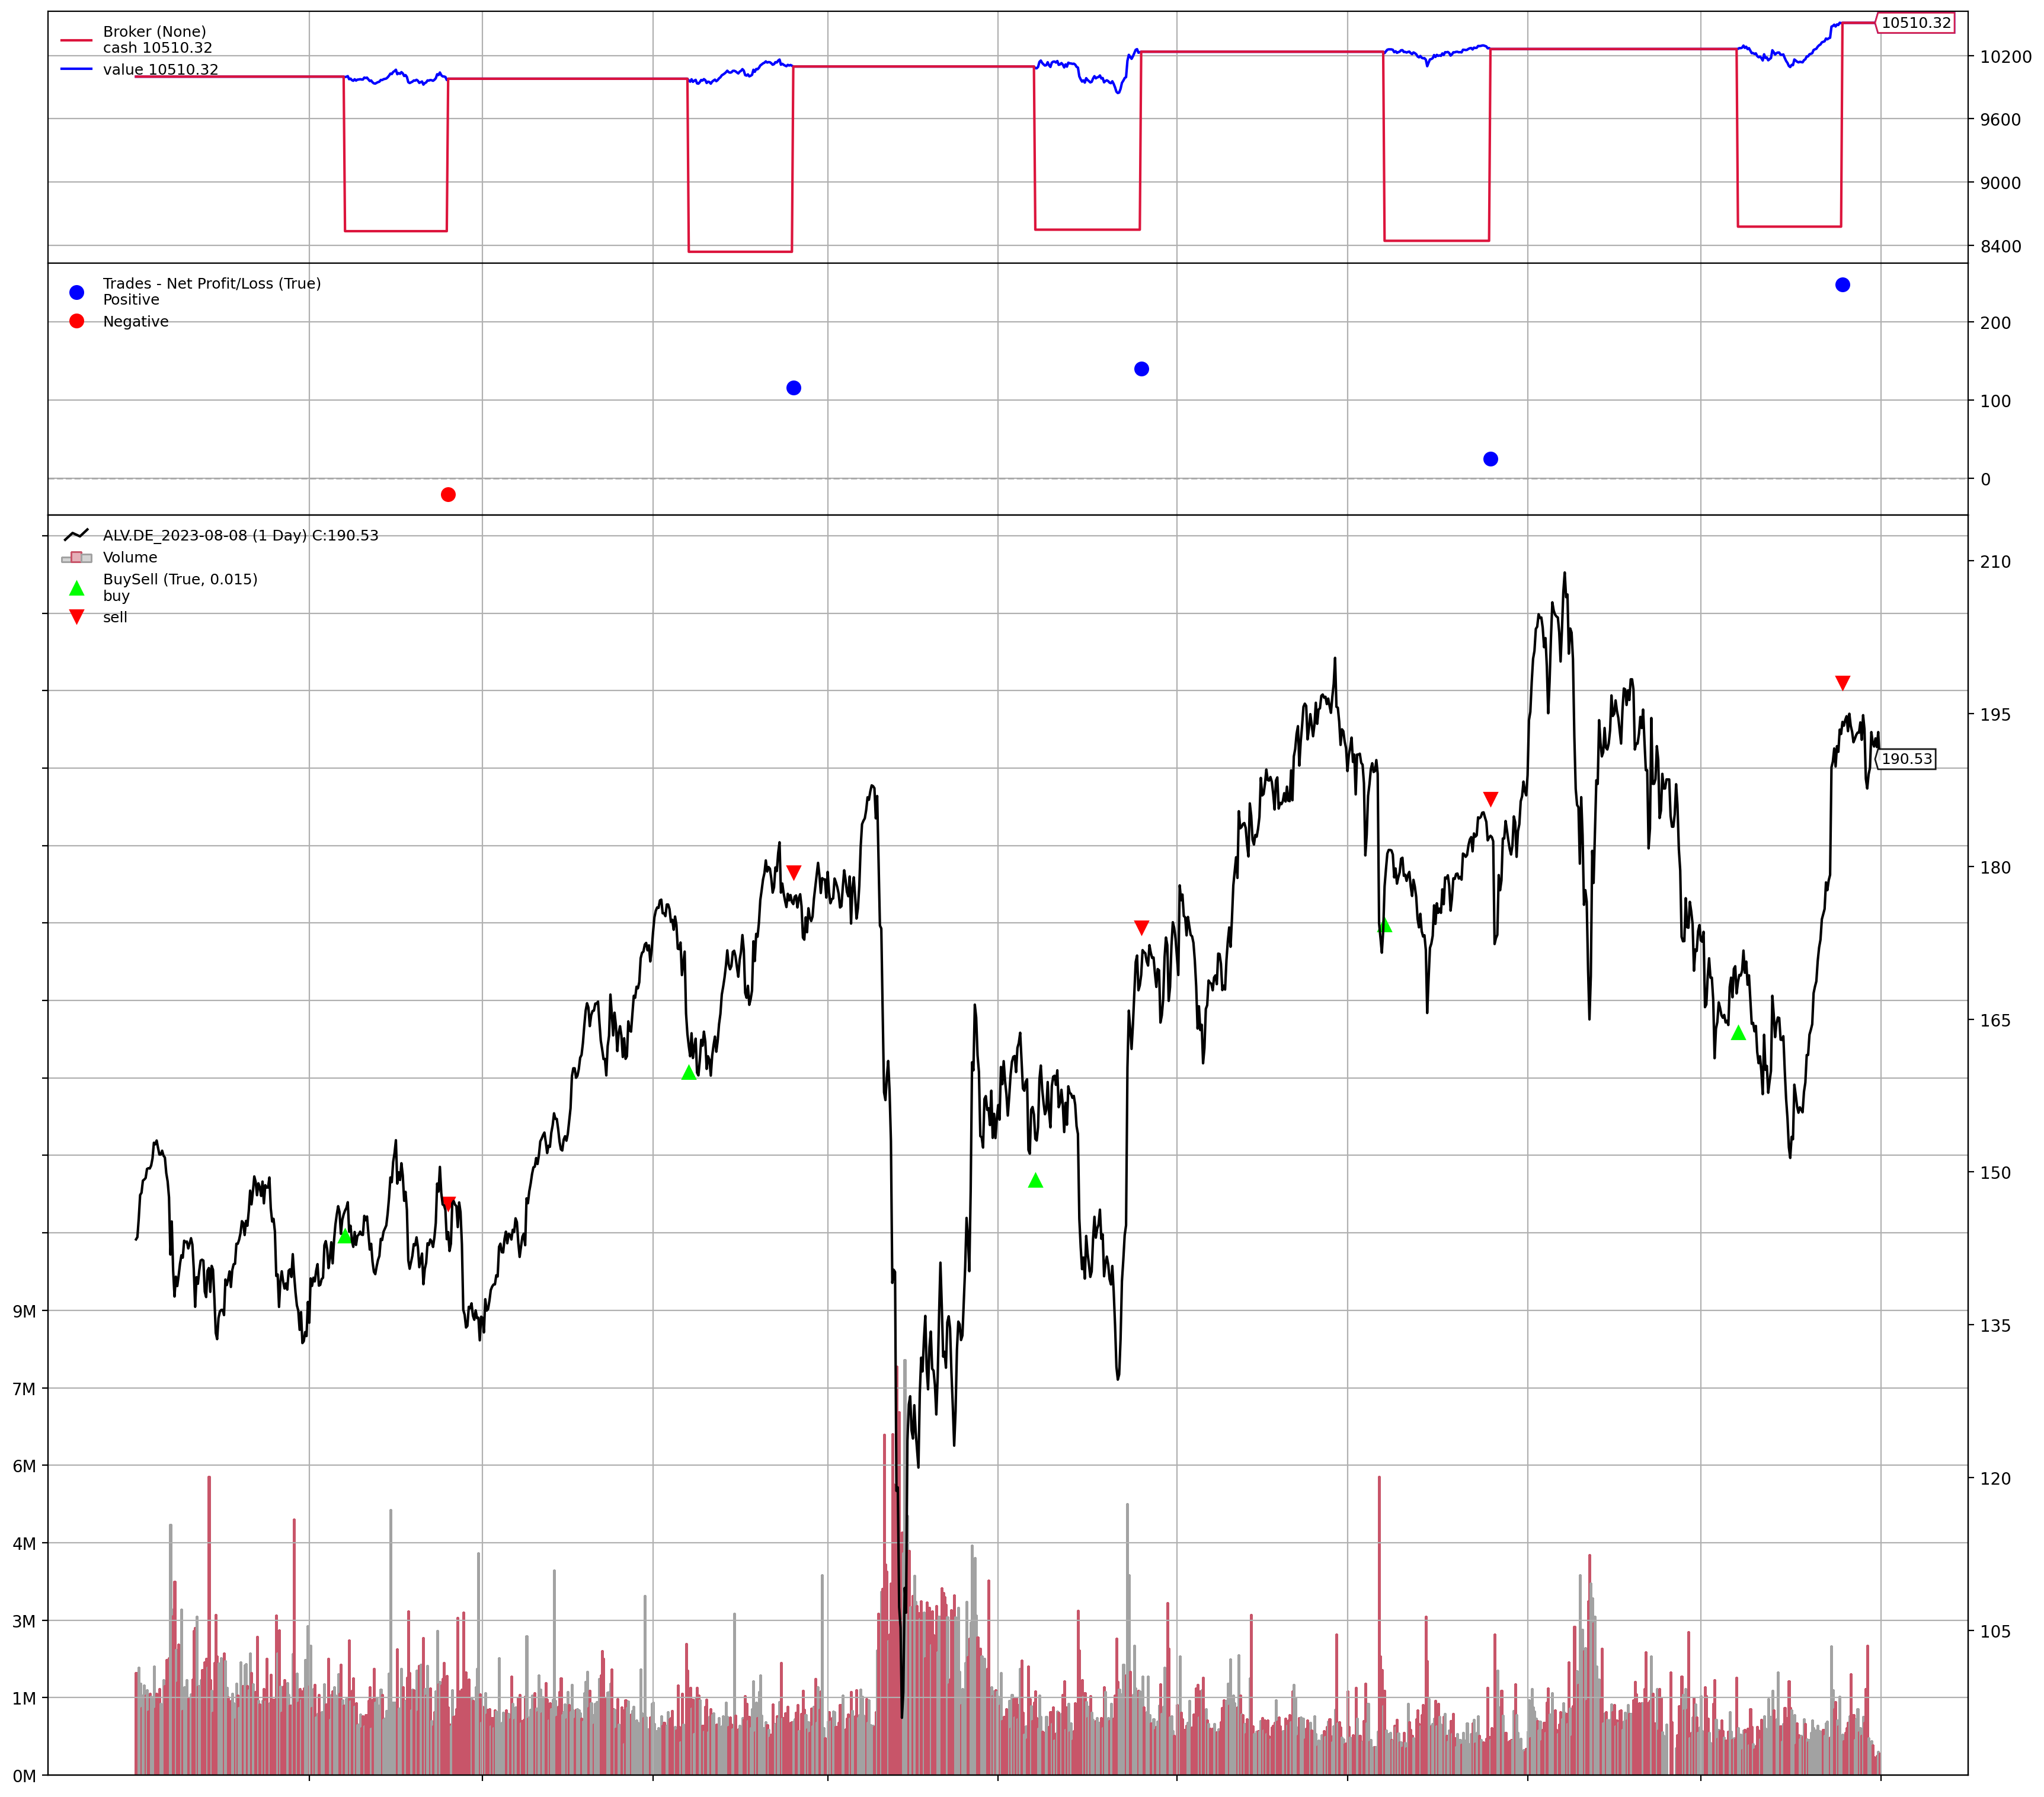

[[<Figure size 3600x3200 with 4 Axes>]]

In [82]:
%matplotlib inline

import datetime # For datetime objects
import os.path  # To manage paths
import datetime as dt
import pickle

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):

    params = (
        ('exitbars', 5),
        ('printlog', False),
        ('yearlyTradeStartDate', dt.datetime.strptime("05-08-2022", "%d-%m-%Y")),
        ('yearlyTradeEndDate', dt.datetime.strptime("20-11-2022", "%d-%m-%Y")),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        
        # Indicators for the plotting show
        #bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        #bt.indicators.WeightedMovingAverage(self.datas[0], period=25, subplot=True)
        #bt.indicators.StochasticSlow(self.datas[0])
        #bt.indicators.MACDHisto(self.datas[0])
        #rsi = bt.indicators.RSI(self.datas[0])
        #bt.indicators.SmoothedMovingAverage(rsi, period=10)
        #bt.indicators.ATR(self.datas[0], plot=False)

    # notification for each change of the status of each order
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm), doprint=True)
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm), doprint=True)
        
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    # notification of each actual trade    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    # notification for each iteration through data
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # update yearlyTradeStartDate and yearlyTradeEndDate to current year
        self.params.yearlyTradeStartDate = self.params.yearlyTradeStartDate.replace(year=self.data.datetime.datetime().year)
        self.params.yearlyTradeEndDate = self.params.yearlyTradeEndDate.replace(year=self.data.datetime.datetime().year)

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are not in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.params.yearlyTradeStartDate <= self.data.datetime.datetime() <= self.params.yearlyTradeEndDate:

                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if not self.params.yearlyTradeStartDate <= self.data.datetime.datetime() <= self.params.yearlyTradeEndDate:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    # notification before starting interation through data
    def start(self):
        self.log('(MA Period %2d) Starting Value %.2f' % (self.params.exitbars, self.broker.getvalue()), doprint=True)

    # notification after final interation through data
    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' % (self.params.exitbars, self.broker.getvalue()), doprint=True)


# load info from analyzer
dirname = '.downloads'
pickleFilename = f"{dirname}{os.path.sep}lastAnalysis.pkl"
analyzerInfo = pickle.load(open(pickleFilename, 'rb'))

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=analyzerInfo['historyFilename'],
    # Do not pass values before this date
    fromdate=analyzerInfo['rangeMax5yrs'].min(),
    # Do not pass values after this date
    todate=analyzerInfo['rangeMax5yrs'].max(),
    # Do not pass values after this date
    reverse=False)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Run over everything
cerebro.run(maxcpus=1)

# plot out the strategy
cerebro.plot(iplot=False)